In [ ]:
!pip install ripser

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.8 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18102 sha256=0630fdaa7aa18a40b94490bcf918ce50869c10bb6f0071277a6a92ed8a15307e
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [ ]:
!ls

sample_data


TDA Feature Extractor with BERT Embedding


In [ ]:
import torch
from transformers import BertModel, BertTokenizer
import numpy as np
import pandas as pd
import ripser
from ripser import ripser
from tqdm import tqdm
import math

import numpy as geek


In [ ]:

def find_highest_finite_value_comprehension(data):
    """Finds the highest value in a list, ignoring inf values, using list comprehension."""
    finite_values = [x for x in data if not math.isinf(x)]
    return max(finite_values) if finite_values else -math.inf


def get_second_value_ignoring_inf(data):
    """
    Returns the second non-inf value in a list.

    Args:
      data: A list of numerical values.

    Returns:
      The second non-inf value in the list, or None if not found.
    """
    non_inf_values = [x for x in data if not math.isinf(x)]
    if len(non_inf_values) < 2:
        return None
    return non_inf_values[1]



In [ ]:
import torch
from transformers import BertModel, BertTokenizer
import numpy as np
import pandas as pd
import networkx as nx
from ripser import ripser

def get_bert_attention(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    attention_matrices = torch.stack(outputs.attentions).mean(dim=0).squeeze().numpy()
    return np.mean(attention_matrices, axis=0)  # Averaging across heads

def build_graph(attention_matrix, threshold=0.1):
    graph = nx.Graph()
    num_nodes = attention_matrix.shape[0]

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if attention_matrix[i, j] > threshold:
                graph.add_edge(i, j, weight=attention_matrix[i, j])

    return graph

def compute_tda_features(graph):
    adjacency_matrix = nx.to_numpy_array(graph)
    diagrams = ripser(adjacency_matrix, maxdim=1)['dgms']


    h0 = diagrams[0]
    h1 = diagrams[1] if len(diagrams) > 1 else np.array([])

    num_h0 = geek.count_nonzero(np.round(h0)) #count_nonzero(h0) #len(h0)
    highest_h0 = find_highest_finite_value_comprehension(h0[:, 1] - h0[:, 0]) if num_h0 > 0 else 0
    Second_highest_h0 = get_second_value_ignoring_inf(h0[:, 1] - h0[:, 0]) if num_h0 > 1 else 0
    highest_minus_second_h0 = highest_h0 - Second_highest_h0 if num_h0 > 1 else 0

    # Replace inf values with 0
    h0[np.isinf(h0)] = 0
    mean_h0 = np.mean(h0) if num_h0 > 0 else 0
    # print("mean h0: ", mean_h0)


    num_h1 = geek.count_nonzero(np.round(h1))
    highest_h1 = find_highest_finite_value_comprehension(h1[:, 1] - h1[:, 0]) if num_h1 > 0 else 0
    second_highest_h1 = get_second_value_ignoring_inf(h1[:, 1] - h1[:, 0]) if num_h1 > 1 else 0
    highest_minus_second_h1 = highest_h1 - second_highest_h1 if num_h1 > 1 else 0

    # Replace inf values with 0
    h1[np.isinf(h1)] = 0
    mean_h1 = np.mean(h1) if num_h1 > 0 else 0
    # print("mean h1: ", mean_h1)

    h0_persistences = np.sort(h0[:, 1] - h0[:, 0]) if num_h0 > 1 else np.array([0])

    h1_persistences = np.sort(h1[:, 1] - h1[:, 0]) if num_h1 > 1 else np.array([0])

    # Additional TDA features for linguistic correlation
    sum_persistence_0 = np.sum(h0_persistences) if len(h0_persistences) > 0 else 0
    sum_persistence_1 = np.sum(h1_persistences) if len(h1_persistences) > 0 else 0
    persistence_entropy_0 = -np.sum(h0_persistences * np.log(h0_persistences + 1e-10)) if len(h0_persistences) > 0 else 0
    persistence_entropy_1 = -np.sum(h1_persistences * np.log(h1_persistences + 1e-10)) if len(h1_persistences) > 0 else 0
    betti_curve_0 = len(h0_persistences)
    betti_curve_1 = len(h1_persistences)


    return [num_h0, highest_h0, highest_minus_second_h0, mean_h0, betti_curve_0, persistence_entropy_0,
            num_h1, highest_h1, highest_minus_second_h1, mean_h1, betti_curve_1, persistence_entropy_1]

def process_texts(texts):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    data = []
    for text in tqdm(texts):
        attention_matrix = get_bert_attention(text, model, tokenizer)
        graph = build_graph(attention_matrix)
        tda_features = compute_tda_features(graph)
        data.append(tda_features)

    columns = ["Num_0dim", "Max_0dim", "Max_0dim_Minus_Second", "Mean_0dim", "betti_curve_0", "persistence_entropy_0",
               "Num_1dim", "Max_1dim", "Max_1dim_Minus_Second", "Mean_1dim", "betti_curve_1", "persistence_entropy_1"]
    return pd.DataFrame(data, columns=columns)

# Example usage
texts = ["This is a test sentence.", "Another example of text processing."]
df = process_texts(texts)
print(df)


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
 50%|█████     | 1/2 [00:00<00:00,  4.55it/s]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

   Num_0dim  Max_0dim  Max_0dim_Minus_Second  Mean_0dim  betti_curve_0  \
0         2  0.763828               0.684179   0.099308              8   
1         2  1.240708               1.123605   0.120323              8   

   persistence_entropy_0  Num_1dim  Max_1dim  Max_1dim_Minus_Second  \
0               1.690237         0         0                      0   
1               1.194267         0         0                      0   

   Mean_1dim  betti_curve_1  persistence_entropy_1  
0          0              1                   -0.0  
1          0              1                   -0.0  


Datasets

In [ ]:
import pandas as pd

data_water = pd.read_parquet("hf://datasets/acmc/watermarked_c4_dataset/data/train-00000-of-00001.parquet")

In [ ]:
data_water.head()

,text,timestamp,url,generated,model,results
0,IF we had a consumer confidence index for worl...,2019-04-21 08:44:12,https://www.csmonitor.com/1986/0506/aearl06.html,True,watermarking_facebook/opt-1.3b,"[{'confidence': 0.9999999999998954, 'generated..."
1,What are neutrophils and what do they do?\nNeu...,2019-04-22 22:36:18,http://lp.medicalnewstoday.com/articles/323982...,False,None,"[{'confidence': 0.8047903001943726, 'generated..."
2,It's like walking on hot coals.\nArtificial tu...,2019-04-19 10:50:37,https://www.nydailynews.com/new-york/parks-fak...,False,None,"[{'confidence': 0.8681516859117973, 'generated..."
3,Newsweek news director Cristina Silva will lea...,2019-04-20 14:57:18,https://www.thewrap.com/newsweek-turmoil-conti...,True,watermarking_facebook/opt-1.3b,"[{'confidence': 0.9999999999999994, 'generated..."
4,"Some 3,839 new vehicles were registered in Qat...",2019-04-25 20:12:18,https://www.gulf-times.com/story/561984/More-t...,False,None,"[{'confidence': 0.9903090626982858, 'generated..."


In [ ]:
water = data_water[data_water['generated'] == True][0:500]
nonwater = data_water[data_water['generated'] == False][0:500]

In [ ]:
nonwater_tda = process_texts(nonwater['text'])

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
  0%|          | 1/500 [00:02<16:38,  2.00s/it]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
  0%|          | 2/500 [00:03<15:08,  1.82s/it]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
  1%|          | 3/500 [00:05<14:30,  1.75s/it]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that t

In [ ]:
nonwater_tda

,Num_0dim,Max_0dim,Max_0dim_Minus_Second,Mean_0dim,betti_curve_0,persistence_entropy_0,Num_1dim,Max_1dim,Max_1dim_Minus_Second,Mean_1dim,betti_curve_1,persistence_entropy_1
0,2,4.995294,4.995292,0.007334,427,-4.038338,0,0,0,0,1,-0.0
1,2,5.093984,5.093983,0.008127,398,-4.055658,0,0,0,0,1,-0.0
2,2,4.861957,4.861955,0.006549,390,-6.050226,0,0,0,0,1,-0.0
3,2,4.549612,4.549609,0.010523,383,1.867623,0,0,0,0,1,-0.0
4,2,4.447857,4.447856,0.007654,400,-1.865692,0,0,0,0,1,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,2,4.617254,4.617253,0.007520,385,-3.325143,0,0,0,0,1,-0.0
496,2,4.150354,4.150350,0.006953,381,-2.266022,0,0,0,0,1,-0.0
497,2,4.626259,4.626257,0.009547,370,-0.547784,0,0,0,0,1,-0.0
498,2,4.696598,4.696596,0.007908,379,-3.166829,0,0,0,0,1,-0.0


In [ ]:
water_tda = process_texts(water['text'])

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
  0%|          | 1/500 [00:03<27:19,  3.29s/it]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
  0%|          | 2/500 [00:05<23:37,  2.85s/it]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
  1%|          | 3/500 [00:08<23:38,  2.85s/it]/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that t

In [ ]:
water_tda.to_csv("/content/drive/MyDrive/Data/water_tda.csv", index=False)
nonwater_tda.to_csv("/content/drive/MyDrive/Data/nonwater_tda.csv", index=False)

Linguistic Features

In [ ]:
!pip install textdescriptives

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.3/254.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [ ]:
import spacy
import textdescriptives as td
# load your favourite spacy model (remember to install it first using e.g. `python -m spacy download en_core_web_sm`)
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textdescriptives/all")


In [ ]:
def get_desc(data):
  doc = nlp(data.iloc[0])
  df1 = td.extract_df(doc)

  for text in tqdm(data.iloc[1:]):
    text = nlp(text)
    df2 = td.extract_df(text)
    df1 = df1._append(df2)

  return df1

In [ ]:
# text_feat = get_desc(data_test['text'].iloc[0:50])

/usr/local/lib/python3.11/dist-packages/textdescriptives/components/coherence.py:44: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Span.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarities.append(sent.similarity(sents[i + order]))


In [ ]:
water_feat = get_desc(water['text'])

/usr/local/lib/python3.11/dist-packages/textdescriptives/components/coherence.py:44: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Span.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarities.append(sent.similarity(sents[i + order]))
100%|██████████| 499/499 [01:33<00:00,  5.32it/s]


In [ ]:
nonwater_feat = get_desc(nonwater['text'])

/usr/local/lib/python3.11/dist-packages/textdescriptives/components/coherence.py:44: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Span.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarities.append(sent.similarity(sents[i + order]))
100%|██████████| 499/499 [01:22<00:00,  6.04it/s]


In [ ]:
nonwater_feat.head()

,text,passed_quality_check,n_stop_words,alpha_ratio,mean_word_length,doc_length,symbol_to_word_ratio_#,proportion_ellipsis,proportion_bullet_points,contains_lorem ipsum,...,pos_prop_NOUN,pos_prop_NUM,pos_prop_PART,pos_prop_PRON,pos_prop_PROPN,pos_prop_PUNCT,pos_prop_SCONJ,pos_prop_SYM,pos_prop_VERB,pos_prop_X
0,What are neutrophils and what do they do?\nNeu...,False,137.0,0.860795,4.573864,352.0,0.0,0.0,0.0,0.0,...,0.278409,0.005682,0.022727,0.034091,0.022727,0.107955,0.011364,0.00000,0.130682,0.0
0,It's like walking on hot coals.\nArtificial tu...,False,117.0,0.776623,4.114286,385.0,0.0,0.0,0.0,0.0,...,0.174026,0.064935,0.028571,0.020779,0.163636,0.124675,0.028571,0.00000,0.096104,0.0
0,"Some 3,839 new vehicles were registered in Qat...",False,127.0,0.759878,3.768997,329.0,0.0,0.0,0.0,0.0,...,0.209726,0.072948,0.006079,0.015198,0.069909,0.094225,0.006079,0.00000,0.094225,0.0
0,"""Oh, you are stuck on homework problem number ...",False,164.0,0.753247,3.189610,385.0,0.0,0.0,0.0,0.0,...,0.085714,0.002597,0.020779,0.122078,0.101299,0.174026,0.023377,0.00000,0.124675,0.0
0,"Spot gold was steady at $1,232.08 per ounce, a...",True,151.0,0.810056,4.058659,358.0,0.0,0.0,0.0,0.0,...,0.189944,0.044693,0.008380,0.027933,0.097765,0.100559,0.022346,0.01676,0.075419,0.0


In [ ]:
nonwater_feat['smog']

,smog
0,11.698219
0,11.088447
0,8.841846
0,4.972881
0,11.051254
...,...
0,7.793538
0,13.319298
0,7.928767
0,8.735057


In [ ]:
focus_nonwater_feat = nonwater_feat[['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                              'first_order_coherence', 'flesch_reading_ease', 'flesch_kincaid_grade', 'smog',
                              'n_stop_words', 'doc_length', 'n_unique_tokens']]

focus_water_feat = water_feat[['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                              'first_order_coherence', 'flesch_reading_ease', 'flesch_kincaid_grade', 'smog',
                              'n_stop_words', 'doc_length', 'n_unique_tokens']]

In [ ]:
focus_tda_water = water_tda[["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "persistence_entropy_0"]]
focus_tda_nonwater = nonwater_tda[["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "persistence_entropy_0"]]

Corelation

In [ ]:
!pip install dcor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.2 MB/s eta 0:00:00


In [ ]:
from dcor import distance_correlation

corr_value = distance_correlation(df_scores.to_numpy(), focus_feat.to_numpy())
print("Distance Correlation:", corr_value)


Distance Correlation: 0.2973161266528786


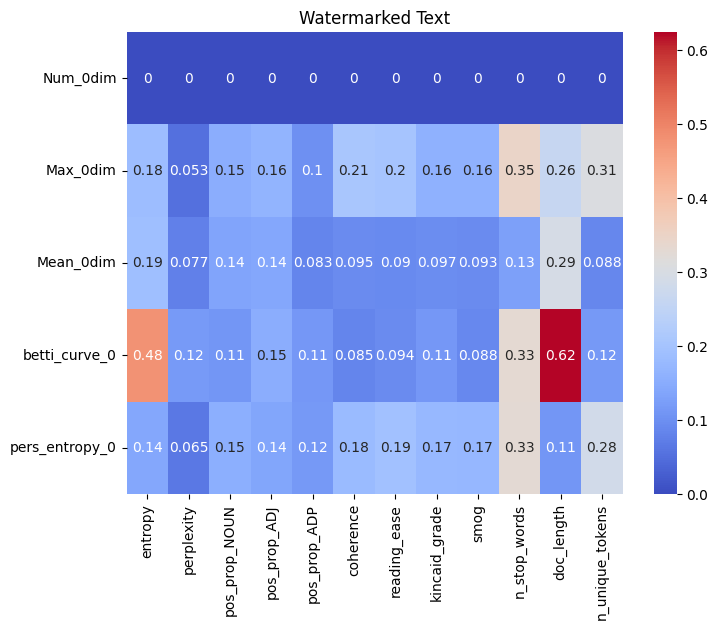

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import dcor
import numpy as np

# # Example: Assume we have multiple TDA and linguistic features
# tda_features = np.random.rand(100, 6)  # 6 TDA features (replace with real data)
# linguistic_features = np.random.rand(100, 4)  # 4 linguistic features (replace with real data)
tda_features = focus_tda_water.to_numpy()
linguistic_features = focus_water_feat.to_numpy()

# Compute pairwise distance correlation matrix
corr_matrix = np.zeros((tda_features.shape[1], linguistic_features.shape[1]))

for i in range(tda_features.shape[1]):
    for j in range(linguistic_features.shape[1]):
        corr_matrix[i, j] = dcor.distance_correlation(tda_features[:, i], linguistic_features[:, j])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",
            xticklabels= ['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                              'coherence', 'reading_ease', 'kincaid_grade', 'smog',
                              'n_stop_words', 'doc_length', 'n_unique_tokens'],
            yticklabels=["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "pers_entropy_0"]
            )
plt.title("Watermarked Text")
plt.show()

#Distance Correlation Heatmap

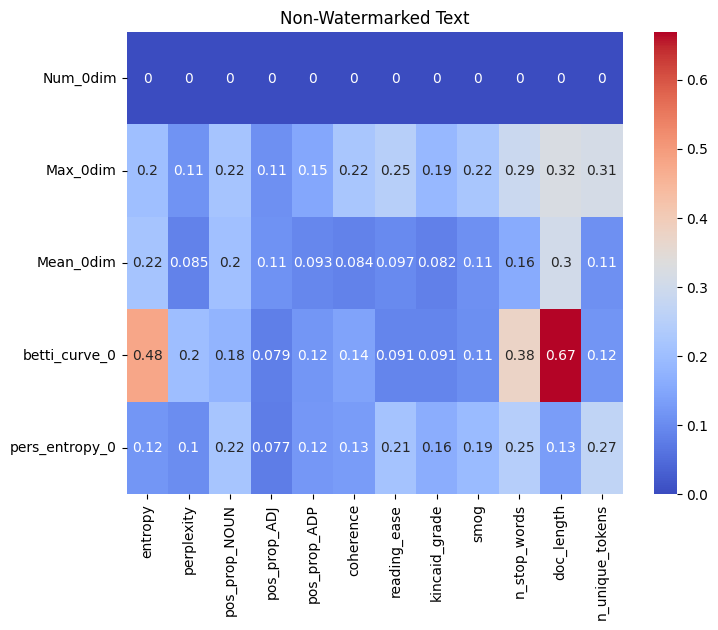

In [ ]:
tda_features = focus_tda_nonwater.to_numpy()
linguistic_features = focus_nonwater_feat.to_numpy()

# Compute pairwise distance correlation matrix
corr_matrix = np.zeros((tda_features.shape[1], linguistic_features.shape[1]))

for i in range(tda_features.shape[1]):
    for j in range(linguistic_features.shape[1]):
        corr_matrix[i, j] = dcor.distance_correlation(tda_features[:, i], linguistic_features[:, j])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",
            xticklabels= ['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                              'coherence', 'reading_ease', 'kincaid_grade', 'smog',
                              'n_stop_words', 'doc_length', 'n_unique_tokens'],
            yticklabels=["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "pers_entropy_0"]
            )
plt.title("Non-Watermarked Text")
plt.show()

TDA Feature Extractor with Attention matrix

In [ ]:
df_scores_at = process_texts(data_test['text'].iloc[0:20])

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is o

In [ ]:
df_scores_at.head()

,Num_0dim,Max_0dim,Max_0dim_Minus_Second,Mean_0dim,Num_1dim,Max_1dim,Max_1dim_Minus_Second,Mean_1dim
0,2,2.189873,2.189773,0.023535,0,0,0,0
1,2,3.473427,3.473424,0.011805,0,0,0,0
2,2,3.755576,3.755573,0.009252,0,0,0,0
3,2,3.563005,3.563001,0.010878,0,0,0,0
4,2,4.366597,4.366594,0.008772,0,0,0,0


In [ ]:
focus_tda_at = df_scores_at[['Num_0dim', 'Max_0dim', 'Max_0dim_Minus_Second', 'Mean_0dim']]